# QUARTERLY EPS PREDICTION FOR MASTERCARD USING SARIMA MODEL

### BY AVI KHANDELWAL

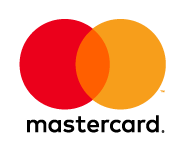

A Time series refers to a set of data points ordered in time having characterstics like-
1. Level - Average value in series
2. Trend - Increasing/Decreasing Values
3. Seasonality - Repeated cycle
4. Noise - Randomness in data

The objective of this project is to understand different components of Time series using the Mastercard EPS (Earnings per share) data of past 15 years and forecast the EPS values for next 2 years.

A seasonal autoregressive integrated moving average (SARIMA) model is a time series modeling technique comprising of 4 features which are-

1. Auto-Regressive: Takes the linear combination of past values of data to predict the next point in future.

2. Moving Average: Takes linear combination of past forecast errors to predict the next point in future.

3. Differencing: Transformation to make Time Series stationary.

4. Seasonality: Repeated cycle

The SARIMA model combines all the above characterstics to make a forecast about future values of Time series data points. It is one of the most practically used statistical approaches to deal with Time series data.



#### Libraries used-

In [2]:
# Statsmodels would be one of the main libraries used for the project

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from google.colab import drive
import seaborn as sns
from sklearn.linear_model import LinearRegression

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [8]:
plt.rcParams['figure.figsize'] = [10, 7.5] 
# Defines a runtime configuration (rc) containing the default styles for every plot element created which in this case is figure size. 

In [5]:
#drive.mount('/content/drive') # Mounting google drive
df1 = pd.read_csv('/content/drive/My Drive/files/Mastercard_eps.csv') # Converting to pandas data frame
df = df1.iloc[::-1]  # Inverting the data bottom up to see a clear trend in time
df.reset_index(drop=True, inplace=True) # Resetting index values
df.head(10)

,date,data (dollars)
0,3/31/2005,0.09
1,6/30/2005,0.09
2,9/30/2005,0.08
3,12/31/2005,0.06
4,3/31/2006,0.09
5,6/30/2006,0.23
6,9/30/2006,0.14
7,12/31/2006,0.03
8,3/31/2007,0.16
9,6/30/2007,0.19


In [6]:
# Descriptive statistics
df.describe()

,data (dollars)
count,64.000000
mean,0.708281
std,0.565704
min,0.010000
25%,0.230000
50%,0.565000
75%,0.890000
max,2.070000


1. Visualising Time Series

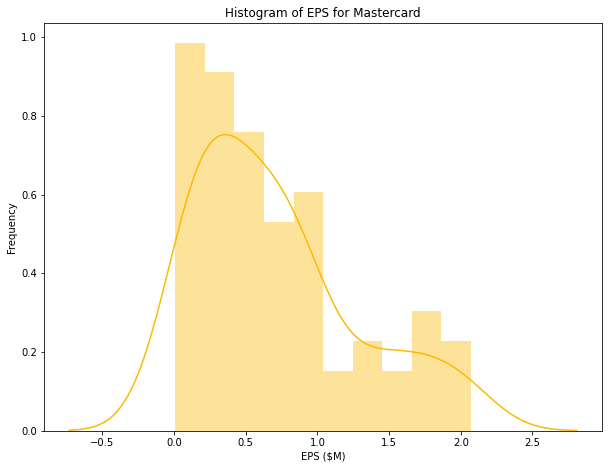

In [9]:
sns.distplot(df['data (dollars)'], bins=10, hist=True, kde=True, color='#fcba03');
plt.title('Histogram of EPS for Mastercard');
plt.xlabel('EPS ($M)');
plt.ylabel('Frequency');

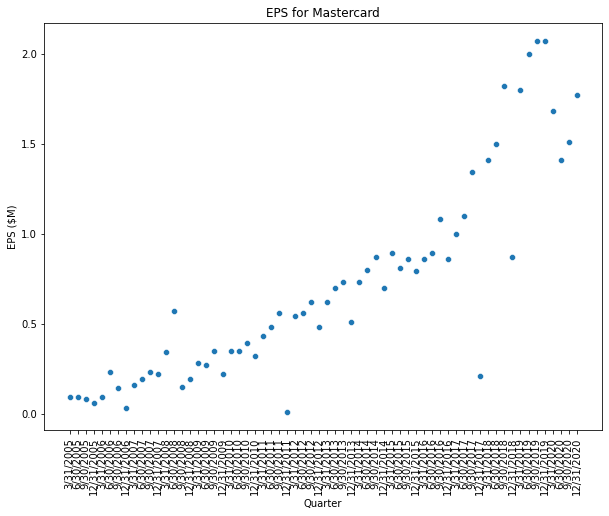

In [10]:
sns.scatterplot(x=df["date"], y=df['data (dollars)']);
plt.title('EPS for Mastercard');
plt.ylabel('EPS ($M)');
plt.xlabel('Quarter');
plt.xticks(rotation=90);

Let us use the most basic technique for fitting this data which is Linear Regression before moving on to advanced models like SARIMA

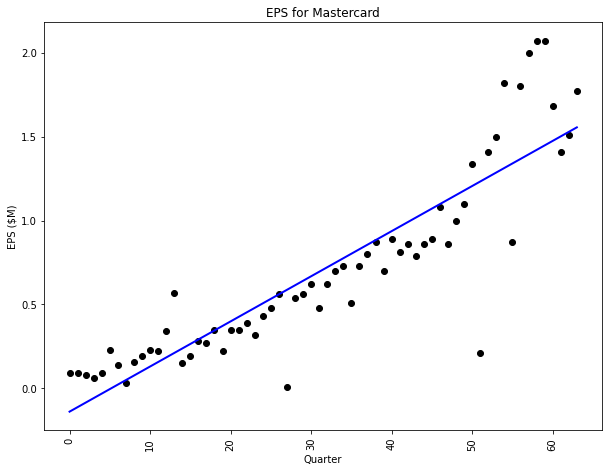

In [11]:
X = np.arange(len(df['data (dollars)'])).reshape(-1, 1)
y = df['data (dollars)'].values.reshape(-1, 1)

reg = LinearRegression()
reg.fit(X, y)

predictions = reg.predict(X.reshape(-1, 1))

plt.scatter(X, y,c='black')
plt.plot(X, predictions, c='blue', linewidth=2)
plt.title('EPS for Mastercard');
plt.ylabel('EPS ($M)');
plt.xlabel('Quarter');
plt.xticks(rotation=90);

From the plot above it can be inferred that Linear Regression for forecasting would be a poor choice of model due to such high deviation between predicted and actual values, hence the motivation to go for advanced statistical models. Let us again plot the given time series data.

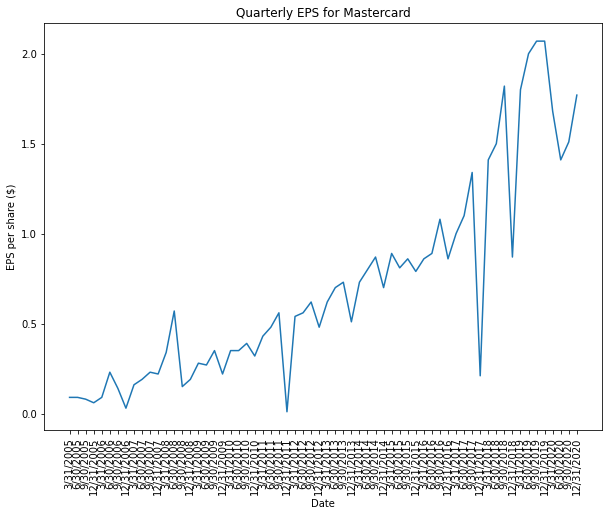

In [12]:
plt.plot(df['date'], df['data (dollars)'])
plt.title('Quarterly EPS for Mastercard')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

A time series is said to be stationary when it's statistical properties do not change with time which primarily means that mean is constant and ACF is a function of lag. A time series with a trend is never stationary. From above we see that Time series magnitude is increasing with time, hence given TS is non-stationary. 

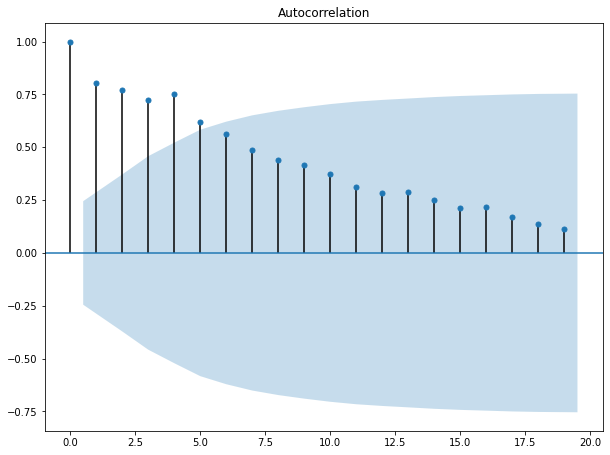

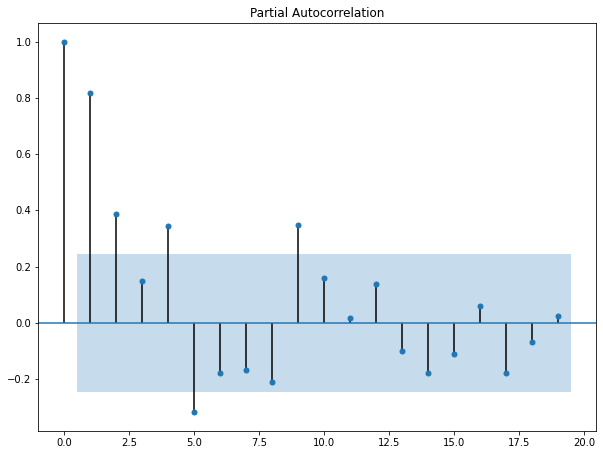

In [13]:
plot_acf(df['data (dollars)']); # Autocorrelation function plot
plot_pacf(df['data (dollars)']); # Partial Autocorrelation function plot

1. For using AR(p) model the ACF plot for given TS should sinosoidally decay and PACF plot should vanish after lag p. It can only be applied on stationary TS.

2. For using MA(q) model the ACF plot should vanish after lag q and PACF plot should sinosoidally decay. It can also be applied on non-stationary TS

For stationary time series, ACF plot should be 1 for lag 0 and insignificant (very small) for all other non-zero values of lag. Clearly from ACF plot, it can again be seen that given TS is non-stationary. 

From above ACF and PACF plots we observe that PACF sinosoidally decays and ACF vanishes after lag 5 hence MA(5) seems like a reasonable choice but due to high parameter order, model coefficients calculation task can take too much time also AR(p) and ARMA(p,q) model can not be applied since TS is non-stationary, hence going for even more advanced models would be a better choice. 

SARIMA model on other hand exploits the seasonality in time series data for better prediction, not only that it can also be applied to non-stationaly TS and model parameters which we would later see would not be very high unlike MA(q), so the whole paramenter estimation task takes comparatively lesser time.

In inferencial statistics, an augmented Dickey–Fuller test (ADF) tests the hypothesis whether a given time series is stationary or not. If the p value comes out to be less than 0.05, null hypothesis can be rejected or in other words given time-series can be considered stationary.

In [14]:
ad_fuller_result = adfuller(df['data (dollars)'])

print(f'p-value: {ad_fuller_result[1]}')

p-value: 0.9574558134725187


Here p value is greater than 0.05, hence the time series is non-stationary just like we established before.

In [15]:
# Taking the Log Difference to make the time series stationary. 
df['Log Diff'] = np.log(df['data (dollars)'])
df['Log Diff'] = df['Log Diff'].diff()

df.head(10)

,date,data (dollars),Log Diff
0,3/31/2005,0.09,NaN
1,6/30/2005,0.09,0.000000
2,9/30/2005,0.08,-0.117783
3,12/31/2005,0.06,-0.287682
4,3/31/2006,0.09,0.405465
5,6/30/2006,0.23,0.938270
6,9/30/2006,0.14,-0.496437
7,12/31/2006,0.03,-1.540445
8,3/31/2007,0.16,1.673976
9,6/30/2007,0.19,0.171850


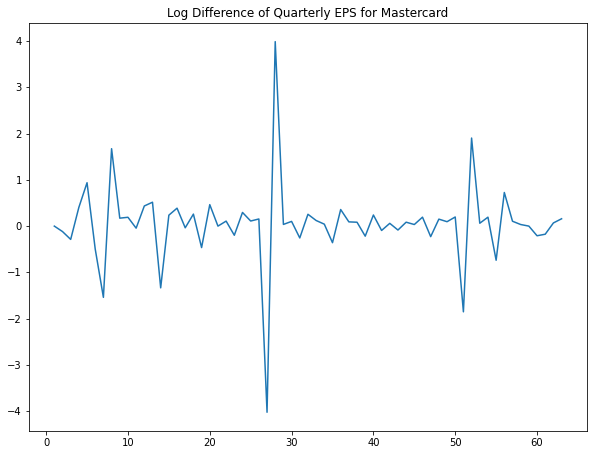

In [16]:
plt.plot(df['Log Diff'])
plt.title("Log Difference of Quarterly EPS for Mastercard")
plt.show()

It now appears that after log-difference operation given time series has lost it's trend, let us again check for stationarity using ad fuller test.

In [17]:
ad_fuller_result = adfuller(df['Log Diff'][1:]) # Excluding the first NaN value

print(f'p-value: {ad_fuller_result[1]}')

p-value: 7.11119878952588e-15


After one differencing operation, we have made the time series stationary since the p value comes much less than 0.05, hence now the time series can further be used for fitting any statistical model.

The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Lower the AIC statistic value, better would be the model for fitting the given time series. Thus, AIC provides a means for model selection.

In [18]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        p - non-seasonal AR order
        q - non-seasonal MA order
        P - seasonal AR order
        Q - seasonal MA order
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=False) # To not display anything while fitting
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

As we had seen earlier one differencing operation was enough to make time series stationary, hence puting d and D as 1. Since the data is quarterly, hence it is seasonal in nature with s = 4 (meaning first quarter eps of one year will be highly corelated with first quarter eps of next year and so on...). Considering all combinations of p,q,P,Q upto maximum value 4, AIC will be calculated and the combination with lowest AIC will be chosen as parameters for modelling.    

In [19]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q) # Generates all possible combinations of p,q,P,Q
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [20]:
result_df = optimize_SARIMA(df['data (dollars)'], parameters_list, 1, 1, 4) # d,D = 1 and s = 4
result_df

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 2, 2)",-0.122230
1,"(0, 1, 3, 2)",1.572156
2,"(1, 1, 2, 2)",1.637346
3,"(0, 2, 2, 2)",1.691970
4,"(1, 2, 2, 2)",2.012676
...,...,...
251,"(3, 0, 1, 0)",32.109786
252,"(0, 0, 2, 0)",32.191046
253,"(1, 0, 1, 0)",32.645752
254,"(0, 0, 0, 0)",40.402396


From above we can see that we get lowest AIC for (p,d,q) = (0,1,1) and (P,D,Q) = (2,1,2) which is comparitively much less in value as compared to MA(5), we had observed earlier. Let us fit out model with MA(5) and SARIMA model and compare which yields better results.  

In [24]:
MA_model = SARIMAX(df['data (dollars)'], order=(0,0,1), seasonal_order=(0,0,0,0))
res1 = MA_model.fit(disp=False)
print(res1.summary()) # Model summary

                           Statespace Model Results                           
Dep. Variable:         data (dollars)   No. Observations:                   64
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -61.158
Date:                Mon, 05 Apr 2021   AIC                            126.316
Time:                        08:47:01   BIC                            130.634
Sample:                             0   HQIC                           128.017
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6458      0.082      7.917      0.000       0.486       0.806
sigma2         0.3925      0.066      5.952      0.000       0.263       0.522
Ljung-Box (Q):                      182.66   Jarque-

From above we observe AIC value is 126 which is much bigger than -0.123 which we were getting for SARIMA, hence SARIMA model is in fact better and should be using for fitting the time series.

In [25]:
best_model = SARIMAX(df['data (dollars)'], order=(0,1,1), seasonal_order=(2,1,2,4))
res = best_model.fit(disp=False)
print(res.summary()) # Model summary

                                 Statespace Model Results                                
Dep. Variable:                    data (dollars)   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(2, 1, 2, 4)   Log Likelihood                   6.061
Date:                           Mon, 05 Apr 2021   AIC                             -0.122
Time:                                   08:47:10   BIC                             12.343
Sample:                                        0   HQIC                             4.744
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6503      0.091     -7.154      0.000      -0.828      -0.472
ar.S.L4        0.6790      0.271      2.504

Residual is defined as the difference between actual value and predicted value of a time series data point. An indicator that a model is fitting the data well is when we see that residuals are normally distributed i.e. when we take a difference between actual values and predicted values for a time series, we get gaussian noise plot, if this happens model is in fact working pretty well.

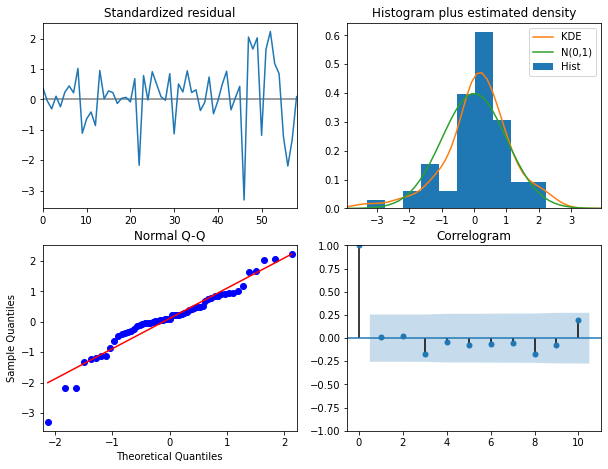

In [26]:
# Further evaluating the performance of our model
res.plot_diagnostics();

1. Standardised Residual plot: It shows that on an average residual value is zero, with slight valriance indicating good model performance.

2. Histogram plot: It shows the normally distributed nature of residuals.

3. Q-Q plot: Quantile-Quantile plot is a scatter plot between 2 sets of quantiles (one from residuals and one drawn from theoretical normal distribution), a straight line would further confirm the normally distributed nature of residuals as we can see above.

4. Correlogram: The ACF plot shows that residuals so obtained are stationary.

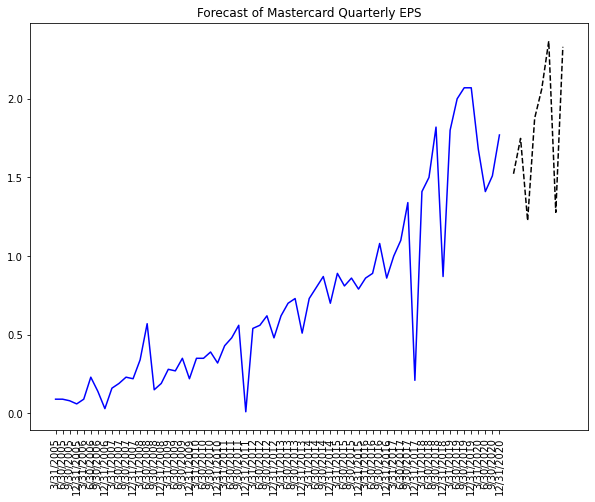

In [44]:
n_forecast = 8 # Forecasting for next 2 years or 8 quarters 

predict = res.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(df['date'],df['data (dollars)'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Mastercard Quarterly EPS')
plt.xticks(rotation=90);

In [45]:
# Comparing the model output with actual values
predict_model = res.get_prediction(0)
predicted = np.array(predict_model.predicted_mean)

df['model'] = predicted
df.head(15)

,date,data (dollars),Log Diff,model
0,3/31/2005,0.09,NaN,0.000000
1,6/30/2005,0.09,0.000000,0.090000
2,9/30/2005,0.08,-0.117783,0.090000
3,12/31/2005,0.06,-0.287682,0.080000
4,3/31/2006,0.09,0.405465,0.105000
5,6/30/2006,0.23,0.938270,0.090000
6,9/30/2006,0.14,-0.496437,0.156016
7,12/31/2006,0.03,-1.540445,0.129252
8,3/31/2007,0.16,1.673976,0.125811
9,6/30/2007,0.19,0.171850,0.265286


In [46]:
# Calculating the mean square error between actual and predicted values
mse = mean_squared_error(df['data (dollars)'], df['model'])
print(f'MSE: {mse}')

MSE: 0.03728188137247007


Finally plotting the model predicted values with actual values, it can be seen that the given SARIMA model is in fact a really good fit on the data and can be effectively used for forecasting Mastercard EPS values upto 2 years, afcorse with the assumption that conditions remain same for the next 2 years and there are no exogeneous or outside variables that are a factor in determining EPS value.

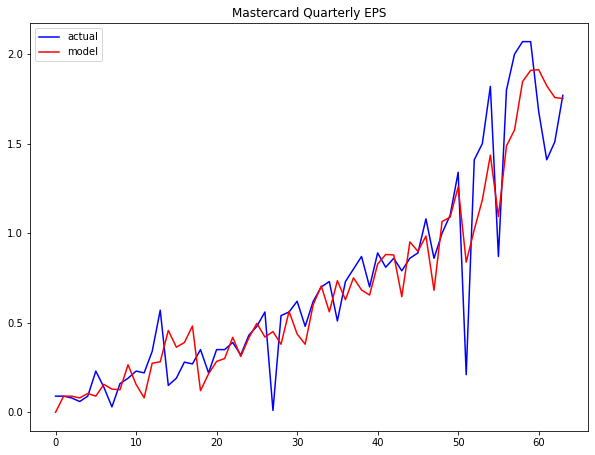

In [32]:
plt.plot(df['data (dollars)'], color='blue', label='actual')
plt.plot(df['model'], color='red', label='model')
plt.legend(loc='best')
plt.title('Mastercard Quarterly EPS')
plt.show()